In [144]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import trange

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

import superfreq as sf

In [7]:
mw = gp.MilkyWayPotential()

In [27]:
pot = gp.CCompositePotential()
pot['disk'] = mw['disk']
pot['halo'] = mw['halo']
pot['bar'] = gp.LongMuraliBarPotential(5e9, a=2., b=0.75, c=0.25, 
                                       units=galactic)

pot.circular_velocity([8.1, 0, 0]*u.kpc)

<Quantity [231.03807999] km / s>

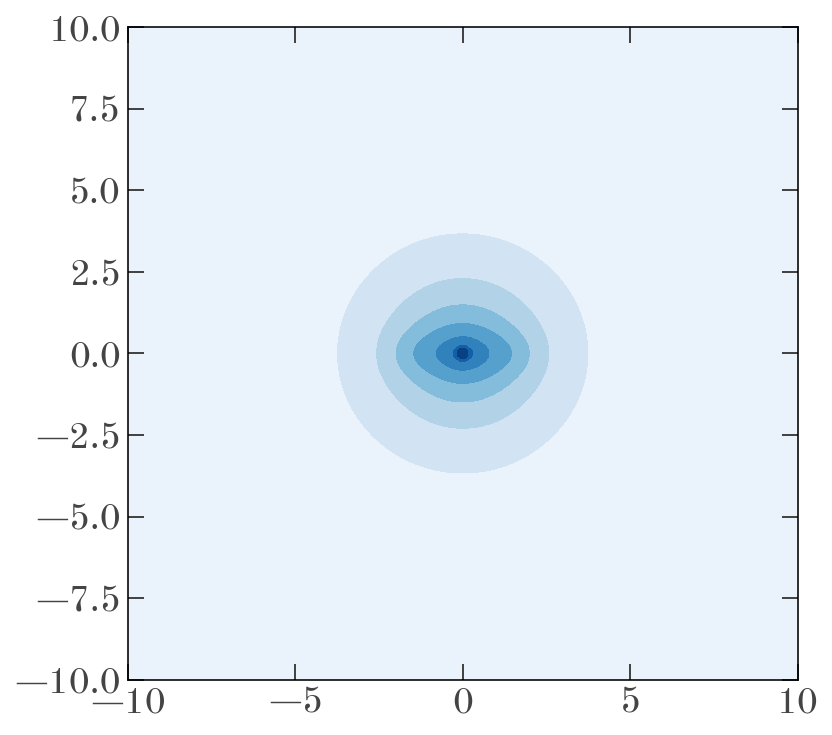

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
_ = pot.plot_density_contours(
    grid=(np.linspace(-10, 10, 128), 
          np.linspace(-10, 10, 128), 
          0.), 
    ax=ax)

In [102]:
Om_p = 40*u.km/u.s/u.kpc
frame = gp.ConstantRotatingFrame(
    [0, 0, -1] * Om_p.to(u.rad/u.Myr, u.dimensionless_angles()), 
    units=galactic)
static_frame = gp.StaticFrame(galactic)

In [103]:
H = gp.Hamiltonian(pot, frame)

$\Omega(R) = \frac{v_c(r)}{R}$

$\kappa(R)^2 = \frac{d^2\Phi}{dR^2} + 3\frac{v_c(R)^2}{R^2}$

In [55]:
R = np.linspace(0, 20, 128) * u.kpc
xyz = np.array([[1, 0, 0]]).T * R[None]
vc = pot.circular_velocity(xyz)
Omega = vc / R

13.070866141732283
9.606299212598426
8.346456692913385
7.716535433070866
7.4015748031496065
7.086614173228346


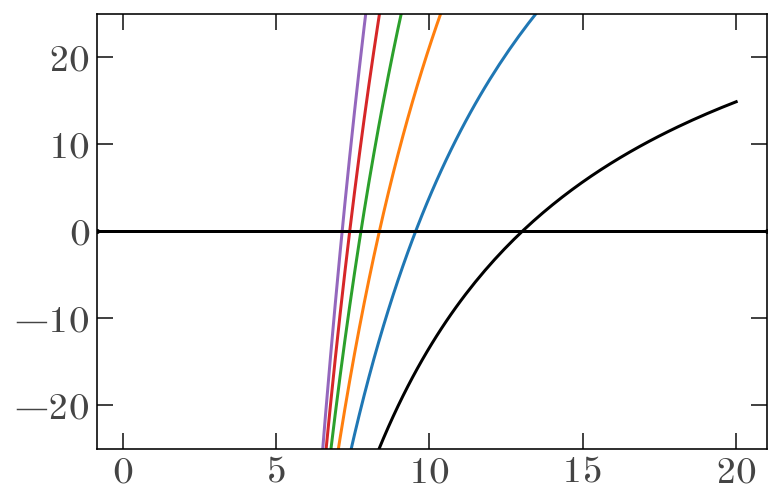

In [163]:
for m in range(1, 6+1):
    lhs = -m * (Omega - Om_p)
    rhs = np.sqrt(pot.hessian(xyz)[0, 0] + 3*Omega**2).to(lhs.unit)
    plt.plot(R.value, lhs - rhs, marker='')
    print(R.value[np.nanargmin(np.abs(lhs - rhs))])

plt.ylim(-25, 25)
plt.axhline(0)

In [92]:
_R_grid = np.linspace(4, 15, 64)
_vR_grid = np.linspace(-50, 50, 64)
R_grid, vR_grid = list(map(np.ravel, np.meshgrid(_R_grid, _vR_grid)))

xyz_grid = np.array([[1, 0, 0]]).T * R_grid[None] * u.kpc

_vphi = pot.circular_velocity(xyz_grid)
vxyz_grid = np.stack((vR_grid,
                      -_vphi.to_value(u.km/u.s),
                      np.zeros(len(_vphi)))) * u.km/u.s

In [104]:
w0_grid = gd.PhaseSpacePosition(
    pos=xyz_grid,
    vel=vxyz_grid)

In [145]:
freq_diffs = []

for i in trange(w0_grid.shape[0]):
    orbit = H.integrate_orbit(w0_grid[i], dt=1., t1=0, t2=100*u.Gyr,
                              Integrator=gi.DOPRI853Integrator)

    split = orbit.shape[0] // 2

    w_pp = gc.poincarepolar.cartesian_to_poincare_polar(orbit.w().T)
    fs_pp1 = [w_pp[:split, i] + 1j*w_pp[:split, i+3] 
              for i in range(2)]
    fs_pp2 = [w_pp[split:, i] + 1j*w_pp[split:, i+3] 
              for i in range(2)]

    try:
        sfreq1 = sf.SuperFreq(orbit.t.to_value(u.Gyr)[:split])
        res1 = sfreq1.find_fundamental_frequencies(fs_pp1)

        sfreq2 = sf.SuperFreq(orbit.t.to_value(u.Gyr)[split:])
        res2 = sfreq2.find_fundamental_frequencies(fs_pp2)

        freq_diff = (res2.fund_freqs - res1.fund_freqs) / res1.fund_freqs

    except:
        freq_diff = np.full(3, np.nan)

    freq_diffs.append(freq_diff)

freq_diffs = np.array(freq_diffs)

  0%|          | 0/4096 [00:00<?, ?it/s]

In [156]:
max_freq_diff = np.max(freq_diffs, axis=1)

<ipython-input-176-2b820363d0d8>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(R_grid.reshape(shape),

<ipython-input-176-2b820363d0d8>:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(R_grid.reshape(shape),



Text(0, 0.5, '$v_R$ [km/s]')

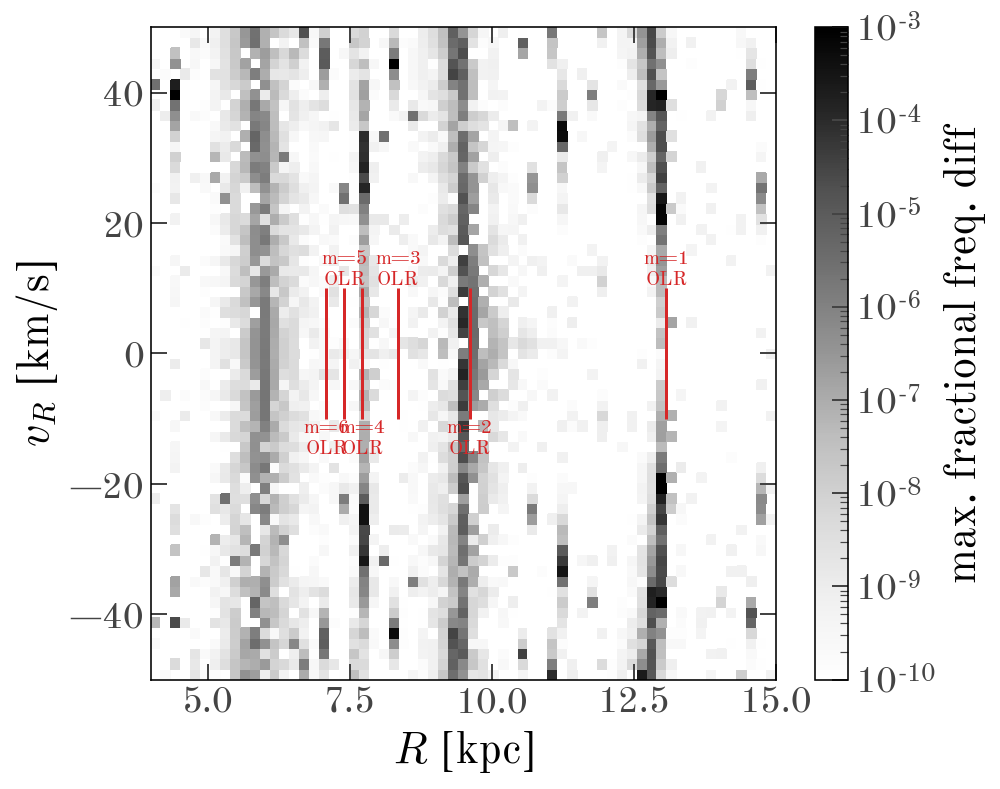

In [176]:
shape = (len(_R_grid), len(_vR_grid))

plt.figure(figsize=(7, 6))
plt.pcolormesh(R_grid.reshape(shape), 
               vR_grid.reshape(shape),
               max_freq_diff.reshape(shape),
               norm=mpl.colors.LogNorm(),
               vmin=1e-10, vmax=1e-3, 
               cmap='Greys')
cb = plt.colorbar()
cb.set_label('max. fractional freq. diff')

olrs = [13.070866141732283,
9.606299212598426,
8.346456692913385,
7.716535433070866,
7.4015748031496065,
7.08661417]
plt.vlines(olrs, ymin=-10, ymax=10, color='tab:red')

ud = 1.
for m, val in zip(np.arange(1, len(olrs)+1), olrs):
    if ud > 0:
        va = 'bottom'
    else:
        va = 'top'
    plt.text(val, ud * 10, f'm={m}\nOLR', 
             ha='center', color='tab:red', va=va)
    ud *= -1

plt.xlabel('$R$ [kpc]')
plt.ylabel('$v_R$ [km/s]')